,instance,seed,iteration,cost,time,method,time_bin,Instance,size
0,A,s1,1,6.573804e+09,4.83,pid: 3,4.549000,A,small
1,A,s1,2,6.570861e+09,8.55,pid: 2,8.326000,A,small
2,A,s1,3,6.570852e+09,12.26,pid: 3,11.938000,A,small
3,A,s1,4,6.569458e+09,16.27,pid: 6,15.986667,A,small
4,A,s1,5,6.569458e+09,NaN,NaN,17.645000,A,small
...,...,...,...,...,...,...,...,...,...
2945,Y,s9876,10,6.016719e+11,198.29,pid: 4,197.092857,Y,large
2946,Y,s9876,11,6.016719e+11,NaN,NaN,215.066667,Y,large
2947,Y,s9876,12,6.016719e+11,NaN,NaN,246.722857,Y,large
2948,Y,s9876,13,6.013949e+11,258.26,pid: B,264.047500,Y,large


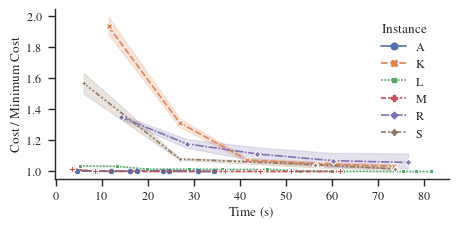

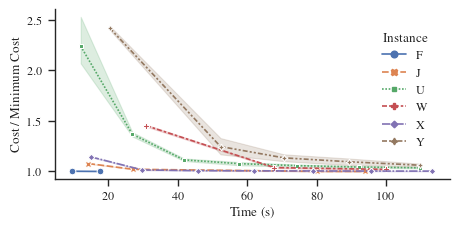

instance
A    0.000000e+00
B    0.000000e+00
C    0.000000e+00
D    0.000000e+00
E    0.000000e+00
F    0.000000e+00
G    0.000000e+00
H    0.000000e+00
I    0.000000e+00
J    0.000000e+00
K   -2.229304e+07
L    0.000000e+00
M   -9.486000e+05
N   -2.138976e+09
O   -1.459366e+09
P    0.000000e+00
Q    0.000000e+00
R   -3.601431e+09
S   -1.076804e+07
T   -1.987096e+09
U   -9.913464e+07
V    0.000000e+00
W   -2.319566e+11
X   -6.412955e+08
Y   -5.055593e+09
Name: cost, dtype: float64

In [4]:
import sqlite3
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="ticks")
sns.set_context("paper", font_scale=1)
plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

df = pd.read_json('convergence_and_ablation_experiment/convergence.json')

df = df[df['method'] != 'greedy']

# Get minimum cost for each instance
min_costs = df.groupby('instance')['cost'].min()

seeded_min_costs = df.groupby(['instance', 'seed'])['cost'].min()
median_min_costs = seeded_min_costs.groupby('instance').median()
max_iterations = df.groupby('instance')['iteration'].max()

# df = df[df['instance'] != 'W']
df = df[df["instance"] != "V"]
df = df[df["instance"] != "G"]
# df = df[df["instance"] != "X"]
# df = df[df["instance"] != "U"]
# df = df[df["instance"] != "F"]



# Define a dictionary for instance sizes
instance_sizes = {
    'A': 'small',
    'G': 'small',
    'J': 'large',    
    'K': 'small',
    'L': 'small',
    'F': 'large',
    'M': 'small',
    'R': 'small',
    'S': 'small',    
    'W': 'large',
    'U': 'large',    
    'X': 'large',
    'V': 'small',
    'Y': 'large',
}


df = df.loc[df.groupby(["instance", "iteration", "seed"])["cost"].idxmin()]
df["time_bin"] = df.groupby(["instance", "iteration"])["time"].transform("mean")

# Find the maximum iteration for each instance
max_iterations = df.groupby('instance')['iteration'].max()

# Create a complete index for all combinations of instance, seed, and iteration
complete_index = pd.MultiIndex.from_tuples(
    [(instance, seed, iteration) 
     for instance, max_iter in max_iterations.items() 
     for seed in df[df['instance'] == instance]['seed'].unique() 
     for iteration in range(1, max_iter + 1)],
    names=['instance', 'seed', 'iteration']
)

#display(max_iterations,complete_index)

#df = pd.read_json('convergence.json')
# Reindex the dataframe to include all combinations, filling missing rows with NaN
df = df.set_index(['instance', 'seed', 'iteration']).reindex(complete_index).reset_index()



df['cost'] = df.groupby(['instance', 'seed'])['cost'].fillna(method='ffill')

# Fill missing time values based on the mean time for each instance and iteration
df["time_bin"] = df.groupby(["instance", "iteration"])["time"].transform("mean")

# df = df[df['time'] <= 150]

df["Instance"] = df["instance"]
# Map the sizes to the dataframe
df["size"] = df["instance"].map(instance_sizes)
display(df)


df['cost'] = df.apply(lambda row: row['cost'] / median_min_costs[row['instance']], axis=1)

g = sns.relplot(
    data=df[(df["size"] == "small") &  (df["time_bin"] <= 85)],
    x="time_bin",
    y="cost",
    hue="Instance",
    style="Instance",
    hue_order=["A", "K", "L", "M","R", "S"],
    kind="line",
    markers=True,
    height=1.7,
    aspect=2,
)



plt.xlabel("Time (s)")
plt.ylabel("Cost / Minimum Cost")
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.8, 0.98))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()

g = sns.relplot(
    # ax=ax_left,
    data=df[(df["size"] == "large") & (df["time_bin"] <= 120)],
    x="time_bin",
    y="cost",
    hue="Instance",
    style="Instance",
    hue_order=["F", "J", "U", "W", "X", "Y"],
    kind="line",
    #kind="swarm",
    markers=True,
    height=1.7,
    aspect=2,
)



plt.xlabel("Time (s)")
plt.ylabel("Cost / Minimum Cost")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.93))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()

min_costs - median_min_costs

,instance,seed,solver_time,greedy_time,before_greedy,after_greedy,iteration,time,Instance,size,time_bin
121,A,s1,3.05373,0.181167,6573867627,6573803925,1,4.66734,A,small,4.210082
1881,A,s1457,3.04133,0.163197,6573804304,6573803925,1,4.63180,A,small,4.210082
3674,A,s2468,2.90815,0.190251,6573867619,6573803925,1,4.25549,A,small,4.210082
5515,A,s3579,2.99597,0.173336,6573835248,6573803880,1,4.35151,A,small,4.210082
7448,A,s43,3.01966,0.179108,6573804312,6573803880,1,4.62828,A,small,4.210082
...,...,...,...,...,...,...,...,...,...,...,...
2724,Y,s1457,13.55160,0.735100,600634898243,599267280008,14,299.32700,Y,large,299.438000
4517,Y,s2468,19.34230,0.532648,620046175343,616276182988,14,299.88800,Y,large,299.438000
6375,Y,s3579,18.41060,0.571689,616156450987,614139833157,14,299.79600,Y,large,299.438000
13855,Y,s789,19.76250,0.549825,600911382032,599377845934,14,299.41500,Y,large,299.438000


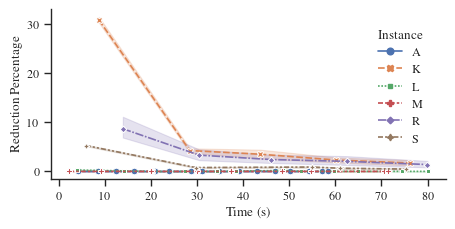

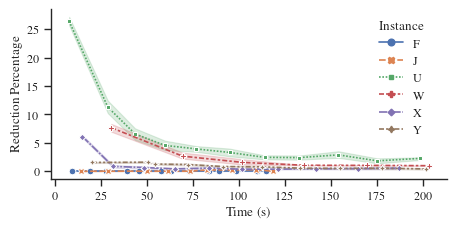

instance
A    0.067324
B    0.000393
C    0.042223
D    0.054972
E    0.235702
F    0.283710
H    0.222641
I    0.130780
J    0.589954
K    0.266696
L    0.101586
M    0.067099
N    0.187516
O    0.320719
P    0.116189
Q    0.207081
R    0.609692
S    0.197419
T    1.026850
U    0.256100
W    1.187175
X    0.633517
Y    0.570585
Name: greedy_time, dtype: float64

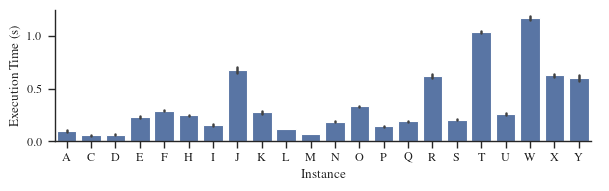

In [7]:
import sqlite3
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="ticks")
sns.set_context("paper", font_scale=1)
plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

df = pd.read_json('convergence_and_ablation_experiment/ablation.json')

df.head(30)

df['Instance'] = df['instance']
# df = df[df['instance'] != 'W']
df = df[df["instance"] != "V"]
df = df[df["instance"] != "G"]
# df = df[df["instance"] != "X"]
# df = df[df["instance"] != "U"]
# df = df[df["instance"] != "F"]


# Create time bins and convert to categorical

# Define a dictionary for instance sizes
instance_sizes = {
    'A': 'small',
    'G': 'small',
    'J': 'large',    
    'K': 'small',
    'L': 'small',
    'F': 'large',
    'M': 'small',
    'R': 'small',
    'S': 'small',    
    'W': 'large',
    'U': 'large',    
    'X': 'large',
    'V': 'small',
    'Y': 'large',
}

# Map the sizes to the dataframe
df['size'] = df['instance'].map(instance_sizes)


# Function to calculate the number of bins dynamically


df['time_bin'] = df.groupby(['instance', 'iteration'])['time'].transform('mean')


df = df.loc[df.groupby(['instance', 'iteration', 'seed'])['before_greedy'].idxmin()]

display(df)


df['greedy_reduction_percentage'] = ((df['before_greedy'] - df['after_greedy']) / df['before_greedy']) * 100

g = sns.relplot(
    data=df[(df["size"] == "small") & (df["time_bin"] <= 85)],
    x="time_bin",
    y="greedy_reduction_percentage",
    hue="Instance",
    style="Instance",
    #kind="swarm",
    hue_order=["A", "K", "L", "M", "R", "S"],
    kind="line",
    markers=True,
    height=1.7,
    # s=3,
    aspect=2,
)

plt.xlabel("Time (s)")
plt.ylabel("Reduction Percentage")
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.8, 0.95))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()

g = sns.relplot(
    data=df[(df["size"] == "large") & (df["time"] <= 200)],
    x="time_bin",
    y="greedy_reduction_percentage",
    hue="Instance",
    style="Instance",
    hue_order=["F", "J", "U", "W", "X", "Y"],
    kind="line",
    markers=True,
    height=1.7,
    aspect=2,
)

plt.xlabel("Time (s)")
plt.ylabel("Reduction Percentage")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 1))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()

greedy_times = df.groupby('instance')['greedy_time'].median()
display(greedy_times)

sns.catplot(data=df[~df["instance"].isin(["V", "B", "G"])], x="Instance", y="greedy_time", kind="bar", height=2, aspect=3)
plt.xlabel("Instance")
plt.ylabel("Execution Time (s)")
plt.tight_layout()

plt.show()

,Team,Total Score
0,10th,3.96e+00
1,11th,2.11e+00
2,12th,2.00e+00
3,13th,1.47e+00
4,14th,1.13e+00
5,15th,9.31e-01
6,16th,9.11e-01
7,17th,5.49e-01
8,18th,5.30e-01
9,19th,2.67e-01


/var/folders/dm/h36jhsdx6wgd0ksg1206pvp40000gn/T/ipykernel_14431/4242570335.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.catplot(


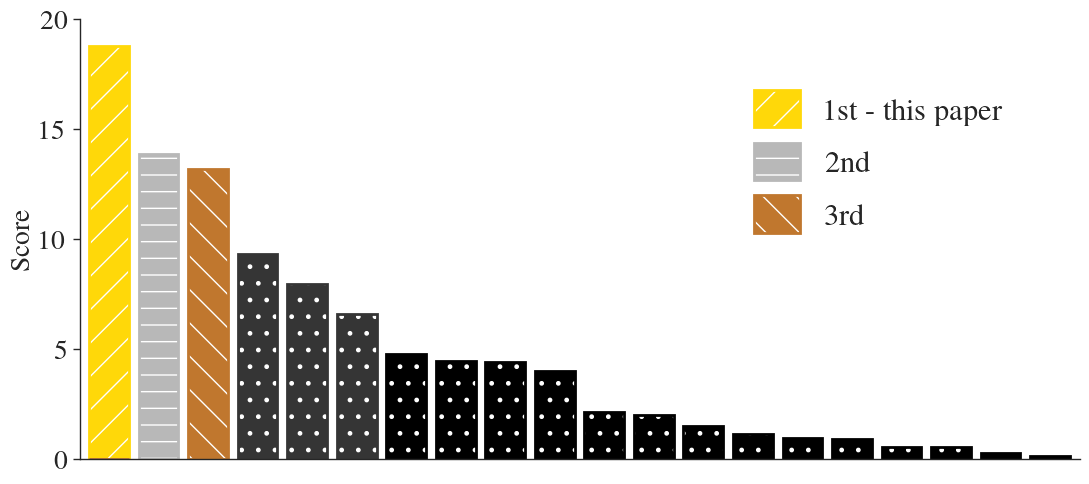

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.axes._axes import Axes
from matplotlib.markers import MarkerStyle
from seaborn import color_palette
from numpy import ndarray
import pandas as pd


result_df = pd.read_csv("./iopddl_final_results.csv")


result_df.iloc[:, 1:] = result_df.iloc[:, 1:].astype(float)

result_df.rename(columns={"TEAM #": "Instance"}, inplace=True)

result_df = result_df[result_df["Instance"] != "XLA"]

result_df.iloc[0, 0] = "1st"
result_df.iloc[1, 0] = "2nd"
result_df.iloc[2, 0] = "3rd"
places = ["1st", "2nd", "3rd"]
for i in range(4,len(result_df)+1):
    result_df.iloc[i-1, 0] = f"{i}th"
    places.append(f"{i}th")

# places.append("XLA")


pd.options.display.float_format = "{:.2e}".format

# Get minimum values per column (excluding 'Instance' column)
min_values = result_df[result_df["Instance"] != "XLA"].iloc[:, 1:].apply(pd.to_numeric, errors="coerce").min()

# Create a new row with the minimum values
min_dict = {"Instance": "Best"}
min_dict.update({col: min_values[i] for i, col in enumerate(result_df.columns[1:])})
min_row = pd.DataFrame([min_dict])

# Create a copy of result_df for scores
scores = result_df.copy()

# Calculate scores for each numeric column (excluding 'Instance')
for col in result_df.columns[1:]:  # Skip 'Instance' column
    min_val = min_values[col]
    scores[f"{col}"] = min_val / result_df[col].astype(float)

scores.set_index("Instance", inplace=True)

scores_melted = scores.reset_index().melt(
    id_vars=['Instance'],
    var_name='Problem',
    value_name='Score'
)
scores_melted.rename(columns={"Instance": "Team", "Problem": "Instance"}, inplace=True)
# scores_melted.dropna(subset=['Score'], inplace=True)
scores_melted['Score'] = scores_melted['Score'].fillna(0)


unique_instances = scores_melted['Instance'].unique()



# Filter out instances A, G, M, S, Y from the scores DataFrame
private_scores = scores_melted[~scores_melted['Instance'].isin(['A', 'G', 'M', 'S', 'Y'])]
# Sum all scores by teams
team_scores = private_scores.groupby('Team')['Score'].sum().reset_index()
team_scores.rename(columns={'Score': 'Total Score'}, inplace=True)

display(team_scores)


tab10  = sns.color_palette("tab10")
runners_up_color = "#353535" #"#BAAB45"
custom_palette = {
    "1st - this paper": "#FFD809",
    "2nd": "#B8B8B8",
    "3rd": "#C0772E",
    # "4th": runners_up_color,
    # "5th": runners_up_color,
    # "6th": runners_up_color,
    # "Runners Up": runners_up_color,
}

# Assign gray to all other teams
for team in team_scores['Team']:
    if team not in custom_palette:
        custom_palette[team] = '#353535'
g2 = sns.catplot(
    data=team_scores,
    x="Team",
    y="Total Score",
    palette=custom_palette,
    order=places,
    height=4,
    aspect=2.5,
    kind="bar",
)

legend_labels = ["1st - this paper", "2nd", "3rd"] #, "Runners Up"]
legend_colors = [custom_palette[label] for label in legend_labels]
for label, color in zip(legend_labels, legend_colors):
    g2.ax.bar(0, 0, color=color, label=label)  # Add invisible bars for legend with increased height


import matplotlib as mpl

hatches = ['/', '-', '\\'] + ['.'] * 3 + ['.'] * (len(team_scores) - 6)
border_colors = ["#FFD809", "#B8B8B8","#C0772E"] + [runners_up_color] * 3 + ['black'] * (len(team_scores) -6)
# Add hatches to the bars
for i, bar in enumerate(g2.ax.patches):
    bar.set_edgecolor(border_colors[i % len(border_colors)])
    bar.set_hatch(hatches[i % len(hatches)])
    bar._hatch_color = mpl.colors.to_rgba("w")
    bar.stale = True
    bar.set_facecolor(border_colors[i % len(border_colors)])
    bar.set_linewidth(2)

plt.ylim(0,20)
g2.ax.yaxis.set_major_locator(plt.MultipleLocator(5))
g2.ax.set_xlabel("")
g2.ax.set_ylabel("Score", fontsize=20)
g2.ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
g2.ax.tick_params(axis='y', labelsize=20)  # Increase font size of y-axis ticks
g2.ax.margins(x=0.01)
g2.ax.legend(
    title="",
    loc="upper center",
    bbox_to_anchor=(0.8, 0.9),
    fontsize=22,
    frameon=False,
    title_fontsize=22,
    handleheight=1.5,
    handlelength=1.5,
)  # Increase font size of legend


plt.tight_layout()
plt.subplots_adjust(top=1.1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.show()

/var/folders/dm/h36jhsdx6wgd0ksg1206pvp40000gn/T/ipykernel_14431/3889615207.py:76: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(


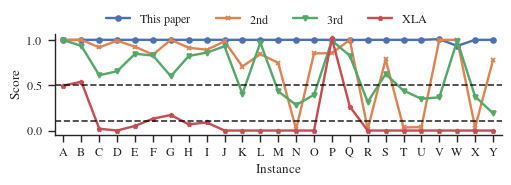

In [10]:
result_df = pd.read_csv("./iopddl_final_results.csv")


result_df.iloc[:, 1:] = result_df.iloc[:, 1:].astype(float)

result_df.rename(columns={"TEAM #": "Instance"}, inplace=True)

#result_df = result_df[result_df["Instance"] != "XLA"]

result_df.iloc[0, 0] = "1st"
result_df.iloc[1, 0] = "2nd"
result_df.iloc[2, 0] = "3rd"
places = ["1st", "2nd", "3rd"]
for i in range(4,len(result_df)):
    result_df.iloc[i-1, 0] = f"{i}th"
    places.append(f"{i}th")

# places.append("XLA")

#display(result_df)

pd.options.display.float_format = "{:.2e}".format

# Get minimum values per column (excluding 'Instance' column)
min_values = result_df[result_df["Instance"] != "XLA"].iloc[:, 1:].apply(pd.to_numeric, errors="coerce").min()

# Create a new row with the minimum values
min_dict = {"Instance": "Best"}
min_dict.update({col: min_values[i] for i, col in enumerate(result_df.columns[1:])})
min_row = pd.DataFrame([min_dict])

# Create a copy of result_df for scores
scores = result_df.copy()

# Calculate scores for each numeric column (excluding 'Instance')
for col in result_df.columns[1:]:  # Skip 'Instance' column
    min_val = min_values[col]
    scores[f"{col}"] = min_val / result_df[col].astype(float)

scores.set_index("Instance", inplace=True)

scores_melted = scores.reset_index().melt(
    id_vars=['Instance'],
    var_name='Problem',
    value_name='Score'
)
scores_melted.rename(columns={"Instance": "Team", "Problem": "Instance"}, inplace=True)
# scores_melted.dropna(subset=['Score'], inplace=True)
scores_melted['Score'] = scores_melted['Score'].fillna(0)


unique_instances = scores_melted['Instance'].unique()


rows = [{"Team": "This paper", "Instance": n, "Score": None}
        for n in unique_instances if n != "W" and n != "V"]


fixed_rows = pd.DataFrame(
    [{"Team": "This paper", "Instance": "W", "Score": 1.18e13/1.264505e13 },
            {"Team": "This paper", "Instance": "V", "Score": 1.63e+06/1.61711600e+06}],
)

scores_melted['Team'] = scores_melted['Team'].replace('1st', 'This paper')

scores_melted = pd.concat(
    [
        scores_melted[~((scores_melted['Instance'].isin(['W', 'V'])) & (scores_melted['Team'] == "This paper"))],
        fixed_rows,
    ],
    ignore_index=True,
)

#display(scores_melted)

g = sns.catplot(
    data=scores_melted,
    x="Instance",
    y="Score",
    hue="Team",
     hue_order=["This paper", "2nd", "3rd", "XLA"],
    kind="point",    
    height=1.7,
    aspect=2.5,    
    markers=["o", "x", "v", "*", "s"],
    scale=0.8,
    # Adjust the x-axis limits to give more space to the first tick
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.52, 0.9), ncol=4, title=None)
plt.tight_layout()



# g.ax.tick_params(axis='x', rotation=45)
plt.axhline(y=0.1, color='black', linestyle='--', alpha=0.8)
plt.axhline(y=0.5, color="black", linestyle="--", alpha=0.8)
# plt.tight_layout()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=20)
#plt.subplots_adjust(top=1.1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.show()

,instance_name,lagrange_cost,lower_bound
0,benchmarks/asplos-2025-iopddl-A.json,6.55e+09,6.51e+09
1,benchmarks/asplos-2025-iopddl-B.json,5.33e+05,5.33e+05
2,benchmarks/asplos-2025-iopddl-C.json,8.41e+10,8.25e+10
3,benchmarks/asplos-2025-iopddl-D.json,3.13e+11,2.98e+11
4,benchmarks/asplos-2025-iopddl-E.json,3.31e+11,3.23e+11
5,benchmarks/asplos-2025-iopddl-F.json,3.61e+11,3.54e+11
6,benchmarks/asplos-2025-iopddl-G.json,2.17e+05,2.17e+05
7,benchmarks/asplos-2025-iopddl-H.json,5.29e+11,5.08e+11
8,benchmarks/asplos-2025-iopddl-I.json,5.85e+11,5.57e+11
9,benchmarks/asplos-2025-iopddl-J.json,1.40e+12,1.11e+12


,instance,seed,cost,lagrange_cost,lower_bound
0,A,s1,6.55e+09,6.55e+09,6.51e+09
1,A,s1457,6.55e+09,6.55e+09,6.51e+09
2,A,s2468,6.55e+09,6.55e+09,6.51e+09
3,A,s3579,6.55e+09,6.55e+09,6.51e+09
4,A,s43,6.55e+09,6.55e+09,6.51e+09
...,...,...,...,...,...
245,Y,s5432,5.95e+11,6.00e+11,4.95e+11
246,Y,s6543,6.01e+11,6.00e+11,4.95e+11
247,Y,s789,5.99e+11,6.00e+11,4.95e+11
248,Y,s8765,5.99e+11,6.00e+11,4.95e+11


,Instance,Cost,Lower Bound,Cost / LB
0,A,6.55e+09,6.51e+09,1.01e+00
1,B,5.33e+05,5.33e+05,1.00e+00
2,C,8.41e+10,8.25e+10,1.02e+00
3,D,3.09e+11,2.98e+11,1.04e+00
4,E,3.39e+11,3.23e+11,1.05e+00
5,F,3.64e+11,3.54e+11,1.03e+00
6,G,2.17e+05,2.17e+05,1.00e+00
7,H,5.28e+11,5.08e+11,1.04e+00
8,I,5.84e+11,5.57e+11,1.05e+00
9,J,1.33e+12,1.11e+12,1.19e+00


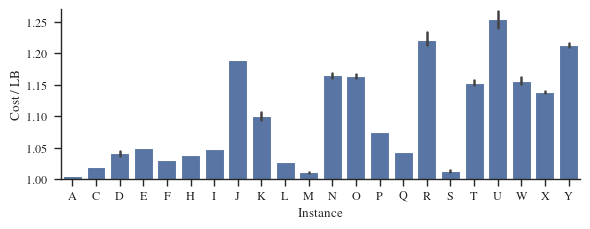

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
db_file =  "lower_bounds/results.db"
conn = sqlite3.connect(db_file)

lb_df = pd.read_sql_query(
    """SELECT instance_name,min(primal_UB) lagrange_cost, max(dual_LB) lower_bound FROM toulbar_results 
    GROUP BY instance_name ORDER BY instance_name ASC """,
    conn,
)


display(lb_df)
lb_df['instance'] = lb_df['instance_name'].str[-6:-5]

# Join lb_df with seeded_min_costs
joined_df = seeded_min_costs.reset_index().merge(
    lb_df[['instance', 'lagrange_cost', 'lower_bound']],
    on='instance',
    how='left',
)

display(joined_df)

joined_df['gap'] = joined_df['cost'] / joined_df['lower_bound']

sns.set(style="ticks")
sns.set_context("paper", font_scale=1)

plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

#gaps_df['instance'] = [chr(65 + i) for i in range(len(gaps_df))]

g = sns.catplot(data=joined_df[~joined_df['instance'].isin(['B', 'G', 'V'])], x='instance', y='gap', height=1.7,
    aspect=3, kind='bar')
sns.despine(top=True, right=True)
plt.ylim(bottom=1.0)
plt.ylim(top=1.27)
plt.xlabel("Instance")
plt.ylabel("Cost / LB")

plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)


median_data = joined_df.groupby('instance')[[ 'cost', 'lower_bound', 'gap']].median()

median_data = median_data.reset_index()

median_data.rename(columns={
    'cost': 'Cost',
    'lower_bound': 'Lower Bound',
    'gap': 'Cost / LB',
}, inplace=True)
median_data.rename(columns={'instance': 'Instance'}, inplace=True)

display(median_data)


filtered_latex_table = median_data.to_latex(
    index=False,
    escape=False,
    float_format=lambda x: f"{x:.2f}" if abs(x - 1.0) < 0.5 else f"{x:.2e}",
    caption="Comparison of our solver's total cost to lower bounds (LB). The last row reports the relative gap, i.e., the ratio between our solver's cost and the lower bound.",
    position="hb",
    label="tab:full_lowerbounds",
    na_rep="N/A",
)


,instance,seed,iteration,cost,time,method,time_bin,Instance,size
0,A,s1,1,6.57e+09,4.43e+00,pid: 3,4.31e+00,A,small
1,A,s1,2,6.57e+09,7.94e+00,pid: 1,8.08e+00,A,small
2,A,s1,3,6.57e+09,NaN,NaN,NaN,A,small
3,A,s1,4,6.57e+09,NaN,NaN,1.43e+01,A,small
4,A,s1,5,6.57e+09,1.90e+01,pid: B,1.80e+01,A,small
...,...,...,...,...,...,...,...,...,...
6645,Y,s9876,10,1.37e+12,NaN,NaN,1.92e+02,Y,large
6646,Y,s9876,11,1.37e+12,NaN,NaN,2.17e+02,Y,large
6647,Y,s9876,12,1.37e+12,NaN,NaN,2.39e+02,Y,large
6648,Y,s9876,13,1.37e+12,NaN,NaN,2.65e+02,Y,large


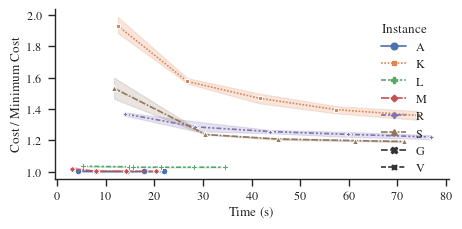

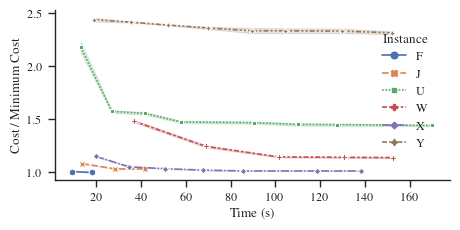

In [20]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="ticks")
sns.set_context("paper", font_scale=1)
plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

df = pd.read_json('convergence_and_ablation_experiment/global_convergence.json')

df = df[df['method'] != 'greedy']


# Get minimum cost for each instance
global_min_costs = df.groupby(['instance', 'seed'])['cost'].min()
first_iteration_costs = df[df['iteration'] == 1].groupby(['instance', 'seed'])['cost'].min()



# Define a dictionary for instance sizes
instance_sizes = {
    'A': 'small',
    'G': 'small',
    'J': 'large',    
    'K': 'small',
    'L': 'small',
    'F': 'large',
    'M': 'small',
    'R': 'small',
    'S': 'small',    
    'W': 'large',
    'U': 'large',    
    'X': 'large',
    'V': 'small',
    'Y': 'large',
}


df = df.loc[df.groupby(["instance", "iteration", "seed"])["cost"].idxmin()]
df["time_bin"] = df.groupby(["instance", "iteration"])["time"].transform("mean")

# Find the maximum iteration for each instance
max_iterations = df.groupby('instance')['iteration'].max()

# Create a complete index for all combinations of instance, seed, and iteration
complete_index = pd.MultiIndex.from_tuples(
    [(instance, seed, iteration) 
     for instance, max_iter in max_iterations.items() 
     for seed in df[df['instance'] == instance]['seed'].unique() 
     for iteration in range(1, max_iter + 1)],
    names=['instance', 'seed', 'iteration']
)

#display(max_iterations,complete_index)

#df = pd.read_json('convergence.json')
# Reindex the dataframe to include all combinations, filling missing rows with NaN
df = df.set_index(['instance', 'seed', 'iteration']).reindex(complete_index).reset_index()



df['cost'] = df.groupby(['instance', 'seed'])['cost'].fillna(method='ffill')

# Fill missing time values based on the mean time for each instance and iteration
df["time_bin"] = df.groupby(["instance", "iteration"])["time"].transform("mean")

# df = df[df['time'] <= 150]

df["Instance"] = df["instance"]
# Map the sizes to the dataframe
df["size"] = df["instance"].map(instance_sizes)
display(df)

# Drop any rows where time_bin or cost is NaN before grouping
# df = df.dropna(subset=["time_bin", "cost"])
# For each seed and time bin, keep only the row with minimum cost
# df = df.loc[df.groupby(['seed', 'time_bin'])['cost'].idxmin().dropna()]
# Divide all costs by their respective instance minimums
df['cost'] = df.apply(lambda row: row['cost'] / min_costs[row['instance']], axis=1)

g = sns.relplot(
    data=df[(df["size"] == "small") &  (df["time_bin"] <= 85)],
    x="time_bin",
    y="cost",
    hue="Instance",
    style="Instance",
    hue_order=["A", "K", "L", "M","R", "S"],
    kind="line",
    markers=True,
    height=1.7,
    aspect=2,
)



plt.xlabel("Time (s)")
plt.ylabel("Cost / Minimum Cost")
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.8, 0.98))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()





g = sns.relplot(
    # ax=ax_left,
    data=df[(df["size"] == "large") & (df["time_bin"] <= 170)],
    x="time_bin",
    y="cost",
    hue="Instance",
    style="Instance",
    hue_order=["F", "J", "U", "W", "X", "Y"],
    kind="line",
    #kind="swarm",
    markers=True,
    height=1.7,
    aspect=2,
)



plt.xlabel("Time (s)")
plt.ylabel("Cost / Minimum Cost")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.93))
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

plt.show()

,instance,median_cost
0,A,6.55e+09
1,B,5.33e+05
2,C,8.41e+10
3,D,3.09e+11
4,E,3.39e+11
5,F,3.64e+11
6,G,2.17e+05
7,H,5.28e+11
8,I,5.84e+11
9,J,1.33e+12


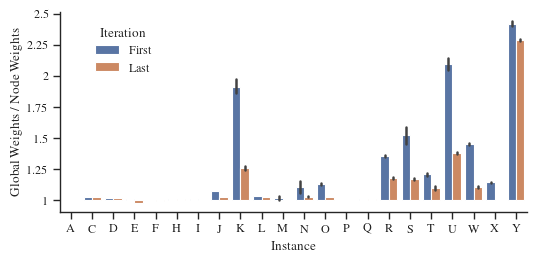

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

global_min_costs = global_min_costs[~global_min_costs.index.get_level_values('instance').isin(['B', 'G', 'V'])]
first_iteration_costs = first_iteration_costs[~first_iteration_costs.index.get_level_values('instance').isin(['B', 'G', 'V'])]

median_min_costs_by_instance = median_min_costs.reset_index()
median_min_costs_by_instance.columns = ['instance', 'median_cost']

display(median_min_costs_by_instance)
global_min_costs_reset = global_min_costs.reset_index()
first_iteration_costs_reset = first_iteration_costs.reset_index()

global_min_costs = global_min_costs_reset.merge(median_min_costs_by_instance, on='instance', how='left')
first_iteration_costs = first_iteration_costs_reset.merge(median_min_costs_by_instance, on='instance', how='left')


global_min_costs['gap'] = global_min_costs['cost'] / global_min_costs['median_cost'] -1
global_min_costs['Iteration'] = "Last"
first_iteration_costs['gap'] = first_iteration_costs['cost'] / first_iteration_costs['median_cost'] -1
first_iteration_costs['Iteration'] = "First"



merged_gaps_df = pd.concat([first_iteration_costs, global_min_costs])



sns.set(style="ticks")
sns.set_context("paper", font_scale=1)

plt.rcParams.update({"text.usetex": True, "font.family": "Times"})

# gaps_df['instance'] = [chr(65 + i) for i in range(len(gaps_df))]


#ax, _ = plt.subplots()

#sns.barplot(data=gaps_first_df, x='instance', y='cost')
#sns.barplot(data=gaps_df, x='instance', y='cost')
g = sns.catplot(data=merged_gaps_df, x='instance', y='gap', hue='Iteration', kind='bar', height=2, aspect=2)



sns.despine(top=True, right=True)
# plt.ylim(bottom=0.95)

# max = plt.gca()
# max.spines['bottom'].set_position(('data', 1.0))
# max.xaxis.set_ticks_position("bottom")
# max.xaxis.set_label_position("bottom")

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v+1:g}"))

plt.xlabel("Instance")
plt.ylabel("Global Weights / Node Weights")

sns.move_legend(g, "upper left", bbox_to_anchor=(0.05, 0.98))

plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)



#display(global_min_costs[~global_min_costs.index.get_level_values('instance').isin(['B', 'G', 'V'])])
#display(first_iteration_costs[~first_iteration_costs.index.get_level_values('instance').isin(['B', 'G', 'V'])])



In [22]:
max_iterations

# Store max_iterations in the results.db database
max_iterations_df = max_iterations.reset_index()

max_iterations_df['instance'] = 'benchmarks/asplos-2025-iopddl-' + max_iterations_df['instance'] + '.json'

max_iterations_df.columns = ['instance', 'max_iteration']

max_iterations_df.to_sql('max_iterations', conn, if_exists='replace', index=False)

print("max_iterations table created successfully")

max_iterations table created successfully


,instance_name,lagrange_cost,lower_bound,seed
0,benchmarks/asplos-2025-iopddl-A.json,6.55e+09,6.15e+18,43
1,benchmarks/asplos-2025-iopddl-B.json,5.33e+05,5.12e+05,1
2,benchmarks/asplos-2025-iopddl-C.json,8.63e+10,8.20e+10,43
3,benchmarks/asplos-2025-iopddl-D.json,3.16e+11,2.85e+11,1
4,benchmarks/asplos-2025-iopddl-F.json,3.61e+11,3.55e+11,1457
5,benchmarks/asplos-2025-iopddl-G.json,2.17e+05,2.17e+05,1
6,benchmarks/asplos-2025-iopddl-H.json,5.29e+11,5.06e+11,789
7,benchmarks/asplos-2025-iopddl-I.json,5.85e+11,5.65e+11,2468
8,benchmarks/asplos-2025-iopddl-J.json,1.40e+12,1.11e+12,789
9,benchmarks/asplos-2025-iopddl-K.json,2.48e+09,1.56e+09,43


,instance,cost,lagrange_cost,lower_bound
0,A,6.55e+09,6.55e+09,6.15e+18
1,B,5.33e+05,5.33e+05,5.12e+05
2,C,8.41e+10,8.63e+10,8.20e+10
3,D,3.09e+11,3.16e+11,2.85e+11
4,E,3.39e+11,NaN,NaN
5,F,3.64e+11,3.61e+11,3.55e+11
6,G,2.17e+05,2.17e+05,2.17e+05
7,H,5.28e+11,5.29e+11,5.06e+11
8,I,5.84e+11,5.85e+11,5.65e+11
9,J,1.33e+12,1.40e+12,1.11e+12


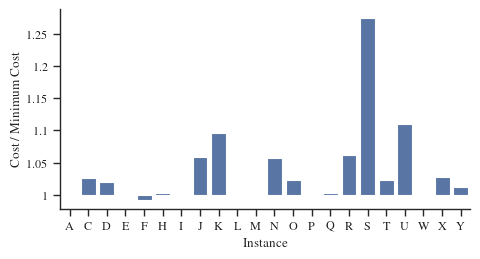

In [26]:
import sqlite3
import pandas as pd
db_file =  "convergence_and_ablation_experiment/quick_results.db"
conn = sqlite3.connect(db_file)

lb_df = pd.read_sql_query(
    "SELECT * FROM toulbar_results GROUP BY instance_name ORDER BY instance_name ASC ",
    conn,
)



lb_df = pd.read_sql_query(
    """SELECT instance_name,min(primal_UB) lagrange_cost, max(dual_LB) lower_bound, seed FROM toulbar_results 
    GROUP BY instance_name ORDER BY instance_name,seed ASC """,
    conn,
)

display(lb_df)


lb_df['instance'] = lb_df['instance_name'].str[-6:-5]

# Join lb_df with seeded_min_costs
joined_df = median_min_costs.reset_index().merge(
    lb_df[['instance', 'lagrange_cost', 'lower_bound']],
    on='instance',
    how='left',
)

display(joined_df)

seeded_min_costs 
median_min_costs = seeded_min_costs.groupby("instance").median()
median_min_costs

joined_df['lagrange_gap'] = (joined_df['lagrange_cost'] / joined_df['cost']) - 1 
joined_df


g = sns.catplot(data=joined_df[~joined_df['instance'].isin(['B', 'G', 'V'])], x='instance', y='lagrange_gap', kind='bar', height=2, aspect=2)


sns.despine(top=True, right=True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v+1:g}"))

plt.xlabel("Instance")
plt.ylabel("Cost / Minimum Cost")

sns.move_legend(g, "upper left", bbox_to_anchor=(0.05, 0.98))

plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)





